# Sysarmy - Predicción de sueldos - 2019.1

## Objetivo

Generar modelos para establecer un sueldo dadas las otras respuestas a las preguntas de la encuesta de sysarmy.

## Metodología

Primero vamos a ver qué respuestas tenemos a cada pregunta independientemente. Esta primera exploración nos da una impresión de los datos disponibles, los posibles outliers (respuestas atípicas), qué datos están desbalanceados (tienen mucha asimetría en las respuestas, por ejemplo muy poca gente de Catamarca responde).

Después vamos a ver cuál es el sueldo promedio y la variabilidad de cada respuesta usando _boxplot_.

Luego generaremos modelos simplificados con una pequeña muestra para entender cómo funcionan. Los modelos a generar serán LinearRegression, KNN, Random Forest, xgboost y CatBoost.

La mayoría de las preguntas, sino todas, son de respuestas de tipo categóricas. Esto suele ser difícil de manejar para modelos de Machine Learning porque se necesita llevar todos los valores a un mismo espacio, es decir, poder establecer un grado de similitud entre un hombre en Jujuy y un hombre en Santa Fe o una mujer en Jujuy. Lo que vamos a hacer para pasar estas columnas a valores numéricos es el promedio de sueldos para ese valor en nuestra muestra de entrenamiento.

Aplicaremos cross validation con 5 folds y usaremos r2 como métrica.

Una vez entrenado

In [1]:
import pandas as pd

df = pd.read_csv('2019.1 - Encuesta de remuneración salarial - Argentina.csv', skiprows=3)
df

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,Orientación sexual,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra
0,Hombre,22,Catamarca,2.0,1.0,1.0,0,Universitario,En curso,ING informática,...,Heterosexual,NaN,NaN,NaN,1001-2000,Producto basado en Software,8,9,2.0,Capacitaciones y/o cursos
1,Hombre,23,Catamarca,2.0,1.0,1.0,0,Secundario,Completado,Ing informática,...,Heterosexual,NaN,NaN,Charlas online,51-100,Producto basado en Software,8,10,2.0,"Capacitaciones y/o cursos, Licencia de paterni..."
2,Mujer,35,Chaco,8.0,7.0,2.0,2,Posgrado,En curso,MTI,...,dgsdg,NaN,No,varios,201-500,Otras industrias,4,4,0.2,"Capacitaciones y/o cursos, Licencia de paterni..."
3,Hombre,41,Chaco,20.0,2.0,10.0,0,Universitario,Completado,Lic en sistemas,...,Heterosexual,NaN,NaN,Ninguno,1-10,Servicios / Consultoría de Software / Digital,5,1,-1.0,"Horarios flexibles, Vacaciones flexibles (adic..."
4,Hombre,35,Chaco,5.0,3.0,2.0,0,Universitario,Completado,Analisis en Sistemas,...,Heterosexual,NaN,No,NaN,501-1000,Producto basado en Software,8,8,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ..."
5,Hombre,38,Chaco,16.0,16.0,16.0,0,Terciario,Incompleto,Analista de Sistemas,...,Heterosexual,NaN,No,Ninguno,201-500,Otras industrias,6,4,2.0,Ninguna de las anteriores
6,Hombre,30,Chaco,9.0,5.0,5.0,3,Terciario,Completado,T S P,...,Heterosexual,NaN,No,NaN,201-500,Otras industrias,6,10,2.0,"Abono de celular y/o Internet, Comidas pagas/s..."
7,Hombre,32,Chaco,10.0,2.0,2.0,0,Universitario,Incompleto,Ing. en Sistemas,...,Heterosexual,NaN,NaN,Ninguno :(,1001-2000,Otras industrias,5,5,5.0,Ninguna de las anteriores
8,Hombre,28,Chaco,7.0,3.0,1.0,2,Universitario,Incompleto,Ingeniería en Sistemas,...,Heterosexual,NaN,No,NaN,51-100,Servicios / Consultoría de Software / Digital,10,5,-1.0,"Horarios flexibles, Vacaciones flexibles (adic..."
9,Hombre,29,Chaco,0.0,0.0,0.0,0,Universitario,En curso,Ingenieria en Sistemas,...,Heterosexual,NaN,No,NaN,501-1000,Producto basado en Software,5,5,3.0,Capacitaciones y/o cursos


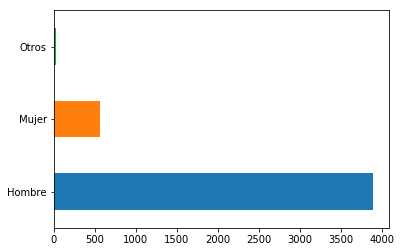

In [2]:
%matplotlib inline
df['Me identifico'].value_counts().plot.barh();

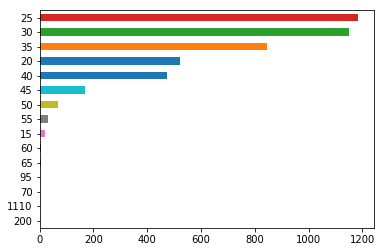

In [3]:
df['Tengo'].apply(lambda x: 5 * (x // 5)).value_counts(sort=True, ascending=True).plot.barh();

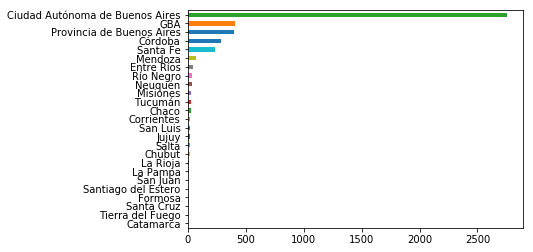

In [4]:
df['Dónde estás trabajando'].value_counts(sort=True, ascending=True).plot.barh();

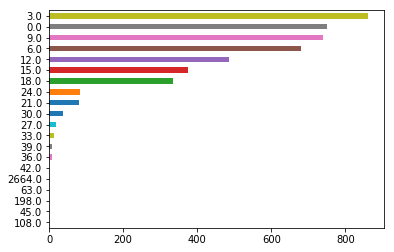

In [5]:
df['Años de experiencia'].apply(lambda x: 3 * (x // 3)).value_counts(sort=True, ascending=True).tail(20).plot.barh();

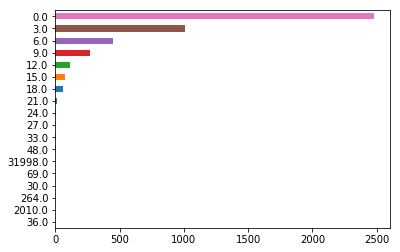

In [6]:
df['Años en la empresa actual'].apply(lambda x: 3 * (x // 3)).value_counts(sort=True, ascending=True).tail(20).plot.barh();

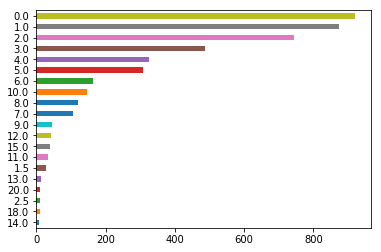

In [7]:
df['Años en el puesto actual'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

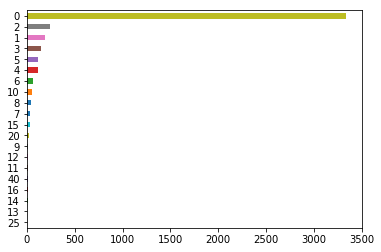

In [8]:
df['¿Gente a cargo?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

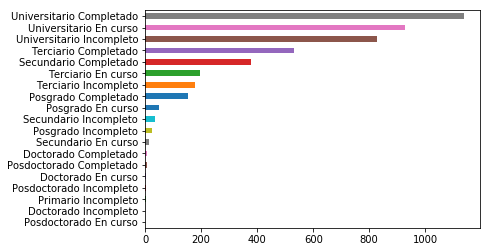

In [9]:
df.apply(lambda row: '{} {}'.format(row['Nivel de estudios alcanzado'], row['Estado']), axis=1).value_counts(sort=True, ascending=True).tail(20).plot.barh();

In [10]:
import re #ahre
regex_replace_map = {
    '^(Ing\.?|In?geni?[ea]r([íi]a|a|o))( en| de|) (.*)$': 'Ingeniería en \\4',
    '^(Ing\.?|Ingeni?er([íi]a|a|o|))$': 'Ingeniería',
    '^[LI]ic(enciatura|enciad[ao]|\.|)( en| de|) (.*)$': 'Licenciatura en \\3',
    '^Analistas?( de| en) (.*)$': 'Analista de \\2',
    '^(Tec\.? |T[eé]cnic(atura|a|o))(.*)$': 'Tecnicatura\\3',
    '^(Dr\.?|Doctor(ado|a|))( en| de|) (.*)$': 'Doctorado en \\4',
    '^Contador(a|).*$': 'Contador Público',
    '^Programador(a|).*$': 'Programación',
    '^(Abocac[íi]a|abogad[ao])$': 'Abogacía',
    '^(.*)ing[\. ](.+)$': '\\1Ingeniería \\2',
    '^(.*)lic[\. ](.+)$': '\\1Licenciatura \\2',
    '^(.*)(mg|mag|magister|maestr[íi]a)[\. ](.+)$': '\\1Maestría \\3',
    '^(.*)informaci[óo]n(.*)$': '\\1Información\\2',
    '^(.*)computaci[óo]n(.*)$': '\\1Computación\\2',
    '^(.*)inform[áàa]tica(.*)$': '\\1Informática\\2',
    '^(.*)programaci[óo]n(.*)$': '\\1Programación\\2',
    '^(.*)licenciatura(.*)$': '\\1Licenciatura\\2',
    '^(.*)electr[óo]nica(.*)$': '\\1Electrónica\\2',
    '^(.*)el[ée]ctrica(.*)$': '\\1Eléctrica\\2',
    '^(.*)tecnolog[íi]a(.*)$': '\\1Tecnología\\2',
    '^(.*)administraci[óo]n(.*)$': '\\1Administración\\2',
    '^(.*)sistem[as]s(.*)$': '\\1Sistemas\\2',
    '^(.*)ingeniero[as](.*)$': '\\1Ingeniería\\2',
    '^(.*)analista(.*)$': '\\1Analista\\2',
    '^(.*)(adm|admin)[ \.](.*)$': '\\1Administración \\2',
    '^(.*)inform[aá]ticos(.*)$': '\\1Informáticos\\2',
    '^(.*)liciencia(.*)$': '\\1licencia\\2', # OMG!
    '^(.*)ciencias?(.*)$': '\\1Ciencias\\2',
    '^(.*)cs\.?(.+)$': '\\1Ciencias\\2',
    '^(.*)an[áàa]lisis(.*)$': '\\1Análisis\\2',
    '^(.*)gesti[óo]n(.*)$': '\\1Gestión\\2',
    '^(.*)ux(.*)$': '\\1UX\\2',
    '^(.*)superior(.*)$': '\\1Superior\\2',
    '^(.*)rrhh(.*)$': '\\1Recursos Humanos\\2',
    '^(.*)empresa(.*)$': '\\1Empresa\\2',
    '^(.*)im[áa]gen(.*)$': '\\1Imágen\\2',
    '^(.*)sonido(.*)$': '\\1Sonido\\2',
    '^(.*)diseño(.*)$': '\\1Diseño\\2',
    '^(.*)electr[óo]nico(.*)$': '\\1Electrónico\\2',
    '^(.*)seguridad(.*)$': '\\1Seguridad\\2',
    '^(.*)higiene(.*)$': '\\1Higiene\\2',
    '^(.*)mec[áa]nica(.*)$': '\\1Mecánica\\2',
    '^(.*)telecomunicaciones(.*)$': '\\1Telecomunicaciones\\2',
    '^(.*)teleinform[áa]tica(.*)$': '\\1Teleinformática\\2',
    '^(.*)industrial(.*)$': '\\1Industrial\\2',
    '^(.*)universitari(.*)$': '\\1Universitari\\2',
    '^(.*)gr[áa]fico(.*)$': '\\1Gráfico\\2',
    '^(.*)desarrollo(.*)$': '\\1Desarrollo\\2',
    '^(.*)software(.*)$': '\\1Software\\2',
    '^(.*)social(.*)$': '\\1Social\\2',
    '^traductor(a|ado|)( P[úu]blico| de .+)?$': 'Traductorado Público',
    '^(.*)p[úu]blico(.*)$': '\\1Público\\2',
    '^(.*)trabajo(.*)$': '\\1Trabajo\\2',
    '^(.*)sitio(.*)$': '\\1Sitio\\2',
    '^(.*)filosof[íi]a(.*)$': '\\1Filosofía\\2',
    '^(.*)redes(.*)$': '\\1Redes\\2',
    '^(.*)psicolog[íi]a(.*)$': '\\1Psicología\\2',
    '^(.*)programador(.*)$': '\\1Programador\\2',
    '^(.*)biom[ée]dic(.*)$': '\\1Biomédic\\2',
    '^(.*)web(.*)$': '\\1Web\\2',
    '^(.*)arte(.*)$': '\\1Arte\\2',
    '^(.*)dela(.*)$': '\\1de la\\2',
    '^(.*)en en(.*)$': '\\1 en \\2',
    '^(.*) de (.*)$': '\\1 de \\2',
    '^(.*) en (.*)$': '\\1 en \\2',
    '^(.*)comunica(dor|dora|ci[óo]n)(.*)$': '\\1Comunicación\\3',
    '^(.*)telecomunicaci[óo]n(es)?(.*)$': '\\1Telecomunicaciones\\3',
    '^(.*)visual(.*)$': '\\1Visual\\2',
    '^fot[óo]graf(a|o|ia|ía)$': 'Fotografía',
    '^(.*)  (.*)$': '\\1 \\2',
    '^(TSP|T S P|T\.S\.P\.?)$': 'Tecnicatura Superior en Programación',
    '^(TSU|T S U|T\.S\.U\.?)(.*)$': 'Tecnicatura Superior Universitaria\\2',
    '^(ISI|I S I|I\.S\.I\.?)$': 'Ingeniería en Sistemas de Información',
    '^(.*)T\.? sup[\.](.*)$': '\\1Tecnicatura Superior\\2',
    '^(Tecnicatura|Ingeniería)( en | )(Industrial|Civil|Electrónic[ao]|Biom[ée]dica|Eléctrica|Mecánica)$': '\\1 \\3',
    '^(Tecnicatura|Ingeniería) Electrónic[ao]$': '\\1 Electrónica',
    '^(Ingeniería|Licenciatura) en Sistemas?(| de Información| en Información| de la Información| Inform[áa]ticos)$': '\\1 en Sistemas de Información',
    '^(.*)Superior Programación(.*)$': '\\1Superior en Programación\\2',
    '^(.*)Tecnicatura Universitario(.*)$': '\\1Tecnicatura Universitaria\\2',
    '^(.*)Tecnicaturaen(.*)$': '\\1Tecnicatura en\\2',
    '^(.*)TecnicaturaSuperior(.*)$': '\\1Tecnicatura Superior\\2',
    '^(.*)TecnicaturaProgramación(.*)$': '\\1Tecnicatura en Programación\\2',
    '^Tecnicatura Programador(.*)$': 'Tecnicatura en Programación',
    '^(LCC|Ciencias Computación|Licenciatura en Computación|Ciencias de la Computación)$': 'Licenciatura en Ciencias de la Computación',
    '^(An[áa]lisis de Sistemas?|Analista( de|) Sistemas?).*$': 'Analista de Sistemas',
    '^(Diseñ(o|ador|adora) Multimedial?|Multimedia)$': 'Diseño Multimedial',
    '^(.*)Universitario en Sistemas(.*)$': '\\1Universitario de Sistemas\\2',
    '^(.*)\.$': '\\1',
}
for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df['Carrera'] = df['Carrera'].str.strip().str.replace(compiled_regex, pattern)

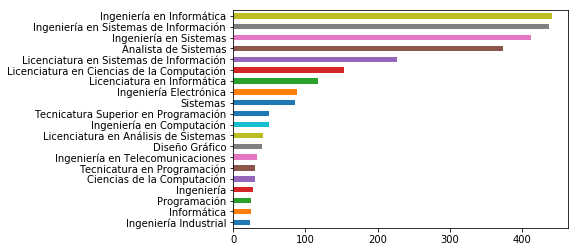

In [11]:
df['Carrera'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

In [12]:
regex_replace_map = {
    '(UTN|UTN .*|UTN ?F.*|Universidad Tec?nol[óo]gica Nacional( F.*)?)$': 'UTN',
    '(UBA|FIUBA|FCE-?UBA|Universidad de Buenos Aires|Buenos Aires)$': 'UBA',
    '(UNLP|Universidad Nacional de La Plata)$': 'UNLP',
    '(UNLaM|Universidad( Nacional|) de la Matanza|la matanza)$': 'UNLaM',
    '(UNS|Universidad Nacional del Sur)$': 'UNS',
    '(UNICEN|Universidad Nacional del Centro( de la (Provincia|Pcia\.?) de Buenos Aires)?)$': 'UNICEN',
    '(UNC|Universidad Nacional de C[óo]rdoba)$': 'UNC',
    '(UNRC|Universidad Nacional de R[ií]o Cuarto)$': 'UNRC',
    '(UNQ|Universidad Nacional de Quilmes|Unqui)$': 'UNQ',
    '(UADE|Universidad Argentina de la Empresa)$': 'UADE',
    '(UB|Universidad de Belgrano)$': 'UB',
    '(UK|(Universidad )?Kennedy)$': 'UK',
    '(UCES|Universidad de Ciencias Empresariales y Sociales)$': 'UCES',
    '(UM|Universidad de Mor[óo]n|Mor[óo]n)$': 'UM',
    '(UP|Universidad de Palermo|Palermo)$': 'UP',
    '(CAECE|UCAECE|Universidad CAECE)$': 'CAECE',
    '(ORT|ORT Argentina)$': 'ORT',
    '(UAI|(Universidad )?Abierta Interamericana)$': 'UAI',
    '(UBP|(Universidad )?Blas Pascal)$': 'UBP',
    '(Universidad )?(Maim[óo]nides)$': 'Maimónides',
    '(UNLA|.*Lan[úu]s)$': 'UNLA',
    '(UNL|(Universidad )?Nacional del Litoral)$': 'UNL',
    '(UNLu|Universidad Nacional de Luj[áa]n)$': 'UNLu',
    '((Escuela .?)?(Multimedial? )?)?Da ?Vinci$': 'DaVinci',
    '(Universidad )?(Siglo 21|Siglo XXI)$': 'Siglo 21',
    '(UA|(Universidad )?Austral)$': 'UNL',
    '(UA|(Universidad )?Austral)$': 'UNL',
    '(Istea)$': 'ISTEA',
    '(UAP|Universidad Adventista del Plata)': 'UAP',
    '(UNJu|Universidad Nacional de Jujuy)': 'UNJu',
    '(UNCUYO|Universidad Nacional de Cuyo)': 'UNCUYO',
    '(ISSD|Instituto Superior Santo Domingo)': 'ISSD',
    '(UNSAM|Universidad Nacional de San Mart[ií]n)': 'UNSAM',
    '(UNLAR|Universidad Nacional de La Rioja)': 'UNLaR',
    '(UNCOMA|Universidad Nacional del Comahue)': 'UNCOMA',
    '(UDA|Universidad del Aconcagua)': 'UDA',
    '(IUA|Instituto Universitario Aeronautico)': 'IUA',
    '(-)$': 'DELETEME',
}
for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df['Universidad'] = df['Universidad'].str.strip().str.replace(compiled_regex, pattern)

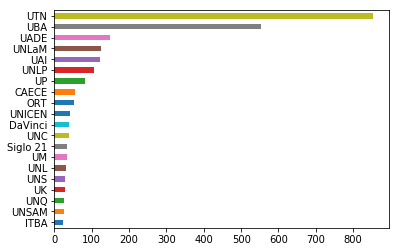

In [13]:
df['Universidad'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

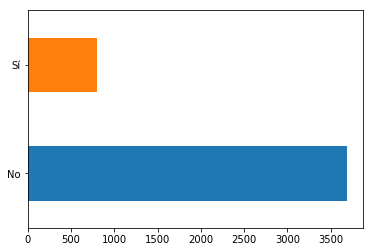

In [14]:
df['¿Contribuís a proyectos open source?'].value_counts().plot.barh();

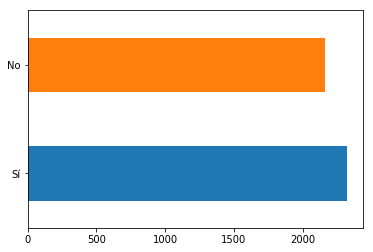

In [15]:
df['¿Programás como hobbie?'].value_counts().plot.barh();

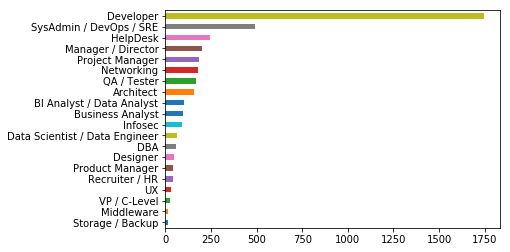

In [16]:
df['Trabajo de'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

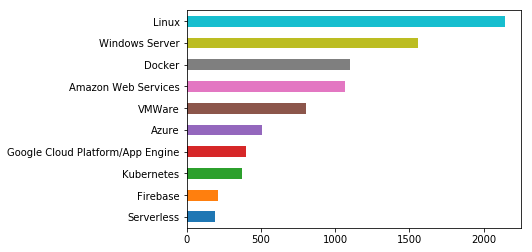

In [17]:
tech_count = {}
for x in df['Plataformas'].dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=True).tail(10).plot.barh();

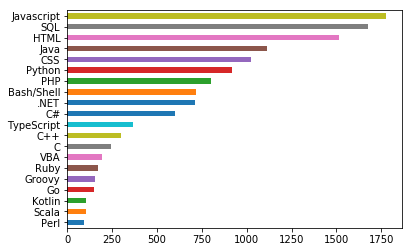

In [18]:
languages_count = {}
for x in df['Lenguajes de programación'].dropna():
    for key in x.split(','):
        key = key.strip()
        languages_count[key] = languages_count.get(key, 0) + 1
pd.Series(languages_count).sort_values(ascending=True).tail(20).plot.barh();

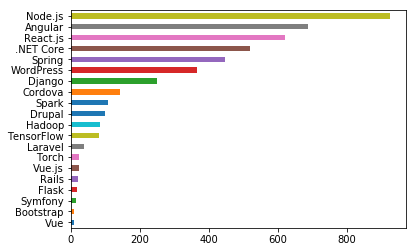

In [19]:
fw_count = {}
for x in df['Frameworks, herramientas y librerías'].dropna():
    for key in x.split(','):
        key = key.strip()
        fw_count[key] = fw_count.get(key, 0) + 1
pd.Series(fw_count).sort_values(ascending=True).tail(20).plot.barh();

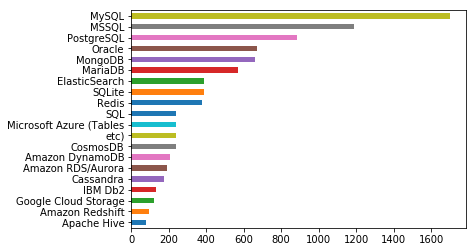

In [20]:
db_count = {}
for x in df['Bases de datos'].dropna():
    for key in x.split(','):
        key = key.strip()
        db_count[key] = db_count.get(key, 0) + 1
pd.Series(db_count).sort_values(ascending=True).tail(20).plot.barh();

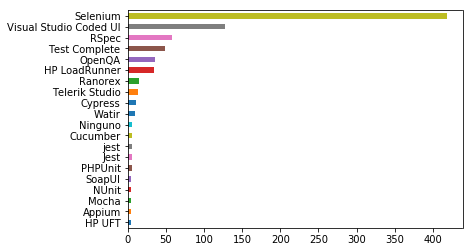

In [21]:
qat_count = {}
for x in df['QA / Testing'].dropna():
    for key in x.split(','):
        key = key.strip()
        qat_count[key] = qat_count.get(key, 0) + 1
pd.Series(qat_count).sort_values(ascending=True).tail(20).plot.barh();

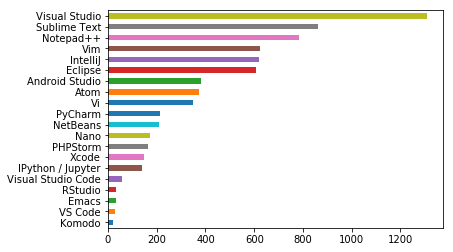

In [22]:
ide_count = {}
for x in df['IDEs'].dropna():
    for key in x.split(','):
        key = key.strip()
        ide_count[key] = ide_count.get(key, 0) + 1
pd.Series(ide_count).sort_values(ascending=True).tail(20).plot.barh();

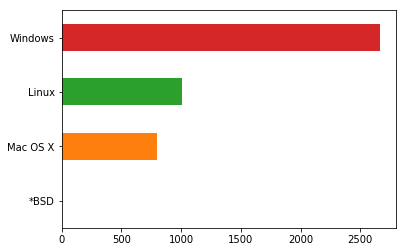

In [23]:
df['¿Qué SO usás en tu laptop/PC para trabajar?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

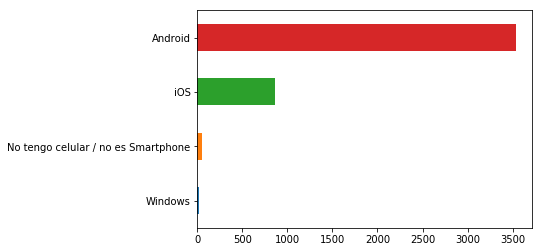

In [24]:
df['¿Y en tu celular?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

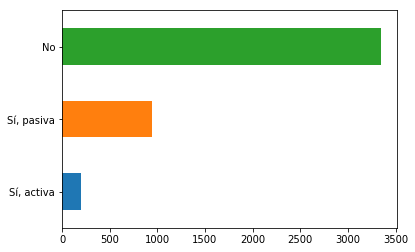

In [25]:
df['¿Tenés guardias?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

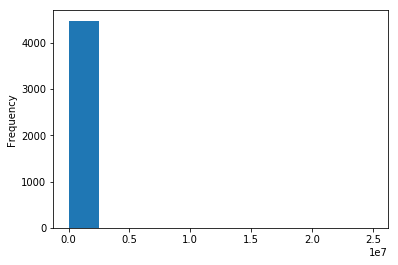

In [26]:
df['Salario mensual BRUTO (en tu moneda local)'].plot.hist();

In [27]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().head()

1906    1.0
2124    1.0
43      1.0
2235    1.0
3916    1.0
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

In [28]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().tail()

3274      931415.92
4029     1500000.00
2349     3572000.00
3169     5138262.00
3919    25000000.00
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

In [29]:
(df['Salario mensual BRUTO (en tu moneda local)'] < 10000).sum()

151

In [30]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] < 12000) & (df['Salario mensual BRUTO (en tu moneda local)'] > 10000)]

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,Orientación sexual,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra
662,Mujer,20,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,...,Heterosexual,NaN,NaN,NaN,201-500,Servicios / Consultoría de Software / Digital,7,9,5.0,"Capacitaciones y/o cursos, Descuentos varios (..."
1075,Mujer,25,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,...,Heterosexual,NaN,NaN,Digital Summit 2018,1001-2000,Servicios / Consultoría de Software / Digital,8,9,9.0,"Capacitaciones y/o cursos, Descuentos varios (..."
1261,Mujer,21,Ciudad Autónoma de Buenos Aires,1.0,1.0,1.0,0,Universitario,En curso,Diseño Gráfico,...,Bisexual o queer,NaN,NaN,NaN,1-10,Producto basado en Software,8,1,8.0,"Horarios flexibles, Vacaciones flexibles (adic..."
1976,Hombre,26,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Terciario,Completado,Diseño Multimedial,...,Pansexual,NaN,No,NaN,1-10,Servicios / Consultoría de Software / Digital,5,5,5.0,Comidas pagas/subvencionadas
2393,Hombre,71,Ciudad Autónoma de Buenos Aires,20.0,3.0,20.0,0,Universitario,Incompleto,Ingeniería,...,Heterosexual,NaN,No,0,11-50,Otras industrias,2,2,5.0,Ninguna de las anteriores
2798,Hombre,22,Córdoba,1.0,1.0,1.0,0,Universitario,En curso,Ingeniería en Software,...,Heterosexual,NaN,NaN,PyData Córdoba,201-500,Otras industrias,6,7,9.6,"Capacitaciones y/o cursos, Descuentos varios (..."
2804,Hombre,20,Córdoba,1.0,1.0,1.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,...,Heterosexual,NaN,NaN,Facebook Developers Circle CBA,11-50,Otras industrias,7,8,8.0,"Capacitaciones y/o cursos, Playroom"
2949,Hombre,38,Córdoba,5.0,5.0,5.0,0,Universitario,En curso,Ingeniería en Telecomunicaciones,...,Heterosexual,NaN,NaN,NaN,51-100,Otras industrias,8,9,4.0,"Capacitaciones y/o cursos, Horarios flexibles"
3124,Hombre,32,Entre Ríos,5.0,4.0,4.0,2,Universitario,En curso,Licenciatura en Sistemas de Información,...,Heterosexual,NaN,No,Conferencias de Seguridad Informática,1-10,Producto basado en Software,6,6,12.0,Ninguna de las anteriores
3890,Hombre,28,Provincia de Buenos Aires,1.0,1.0,1.0,0,Universitario,Completado,Tecnicatura Superior en Programación,...,Heterosexual,NaN,NaN,NaN,1-10,Producto basado en Software,10,10,3.0,"Horarios flexibles, Vacaciones flexibles (adic..."


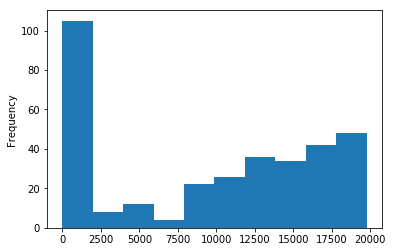

In [31]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] < 20000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist();

In [32]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().tail(20)

59        330000.00
58        332200.00
409       340000.00
3694      356783.00
299       370000.00
500       370000.00
3192      370000.00
591       440000.00
2109      450000.00
3489      550000.00
4129      576000.00
746       600000.00
1274      600000.00
2387      630000.00
2489      720000.00
3274      931415.92
4029     1500000.00
2349     3572000.00
3169     5138262.00
3919    25000000.00
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

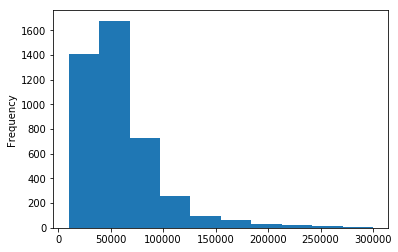

In [33]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist();

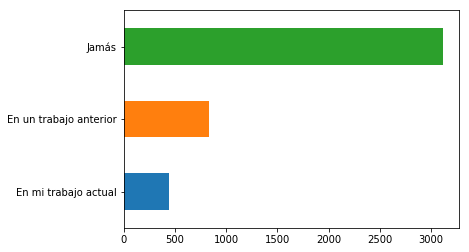

In [34]:
df['¿Sufriste o presenciaste situaciones de violencia laboral?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

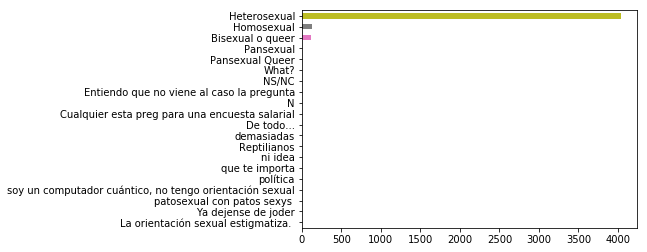

In [35]:
df['Orientación sexual'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

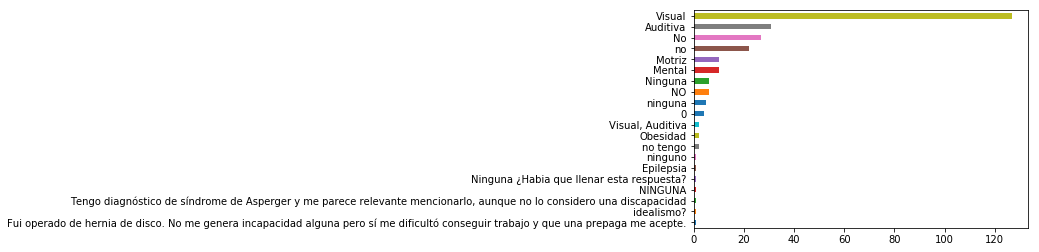

In [36]:
df['¿Tenés algún tipo de discapacidad?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

'reduced in 0.586207'

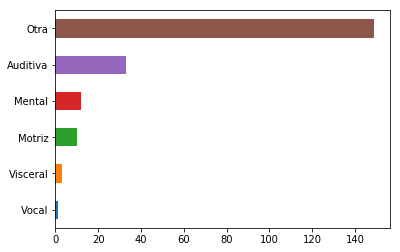

In [37]:
def normalize_dataframe_column(df_in, column_name, regex_assign_map):
  """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
  df_out = df_in.copy()
  for regex, value in regex_assign_map.items():
    compiled_regex = re.compile(regex, re.I)
    mask = df_in[ column_name ].str.strip().str.match(compiled_regex, na=False)
    df_out.loc[ mask, column_name ] = value
  
  # debug
  total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
  display('reduced in {:02f}'.format((total - final) / total))
  return df_out

def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
  """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
  df_out = df_in.copy()
  for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df_out[ column_name ] = df_out[ column_name ].str.strip().str.replace(compiled_regex, pattern)
  
  # debug
  total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
  display('reduced in {:02f}'.format((total - final) / total))
  return df_out

df = normalize_dataframe_column(df, '¿Tenés algún tipo de discapacidad?', {
    '^(_|-|no( tengo)?|ningun[oa]|nada|0|)$': None,
    '.*auditiv[oa].*': 'Auditiva',
    '.*visual.*': 'Visual',
    'mental': 'Mental',
    'motriz': 'Motriz',
    'vis?c?eral': 'Visceral',
    '^no, solo mala vista$': None,
    '^no tengo ninguna discapacidad$': None,
    '^tolerancia$': None,
    '^no tengo discapacidad$': None,
    r'^en serio\?$': None,
    r'^idealismo\?$': None,
    r'^si soy lagarto$': None,
    r'^windows$': None,
    r'^social$': None,
    r'^no les interesa$': None,
    r'^edad$': None,
    r'^ninguna \¿Habia que llenar esta respuesta\?$': None,
})
df['¿Tenés algún tipo de discapacidad?'] = df['¿Tenés algún tipo de discapacidad?'].apply(lambda val: val if val in (None, 'Auditiva', 'Mental', 'Motriz', 'Vocal', 'Visceral') or not isinstance(val, str) else 'Otra')
df['¿Tenés algún tipo de discapacidad?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

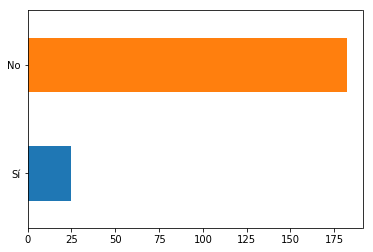

In [38]:
df[~df['¿Tenés algún tipo de discapacidad?'].isna()]['¿Sentís que esto te dificultó el conseguir trabajo?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

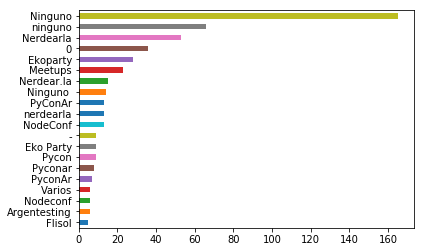

In [39]:
df['¿A qué eventos de tecnología asististe en el último año?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

'reduced in 0.030603'

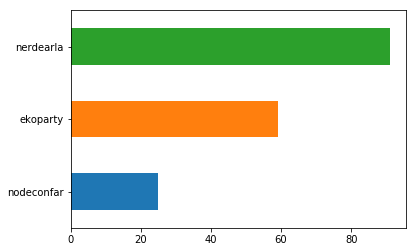

In [40]:
df = normalize_dataframe_column(df, '¿A qué eventos de tecnología asististe en el último año?', {
    '^nerdear\.?la$': 'nerdearla',
    '^eko ?partys?$': 'ekoparty',
    '^pycon(?:ar)?$': 'pyconar',
    '^nodeconf(?:ar)?$': 'nodeconfar',
})

df['¿A qué eventos de tecnología asististe en el último año?'] = df['¿A qué eventos de tecnología asististe en el último año?'].apply(lambda val: val if val in (None, 'nerdearla', 'ekoparty', 'nodeconfar',) or not isinstance(val, str) else None)
df['¿A qué eventos de tecnología asististe en el último año?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

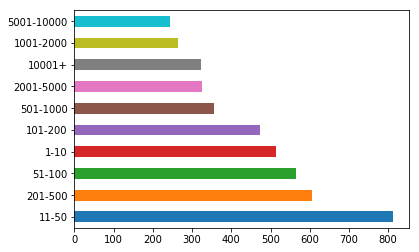

In [41]:
df['Cantidad de empleados'].value_counts().plot.barh();

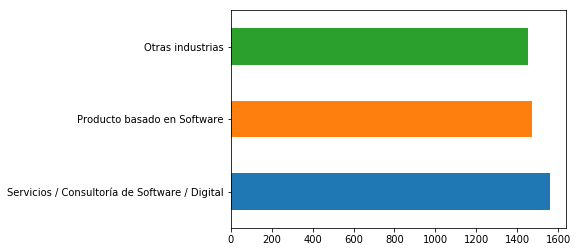

In [42]:
df['Actividad principal'].value_counts().plot.barh();

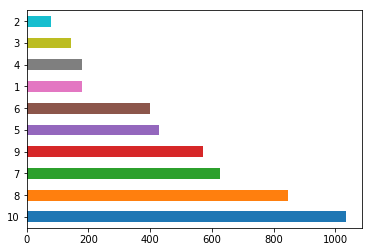

In [43]:
df['¿Cómo calificás las políticas de diversidad e inclusión?'].value_counts().plot.barh();

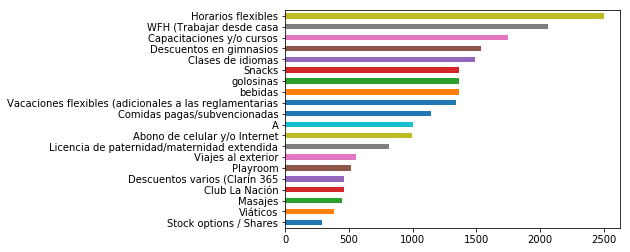

In [44]:
all_benefits = ','.join(df['Beneficios extra'].tolist())
benefits = set(x for x in [item.strip('.,-)()').strip() for s in df['Beneficios extra'].tolist() for item in s.split(',')] if x not in ('', 'a', 'no', 'nada', 'Ninguna', 'etc', 'Ninguna de las anteriores'))
pd.Series({b: all_benefits.count(b) for b in benefits}).sort_values(ascending=True).tail(20).plot.barh();

In [45]:
df = df[df['Años de experiencia'] < 40]
df = df[df['Tengo'] < 80]
df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]

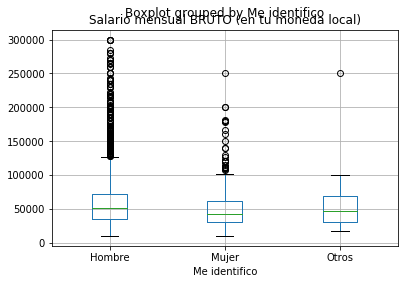

In [46]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Me identifico');

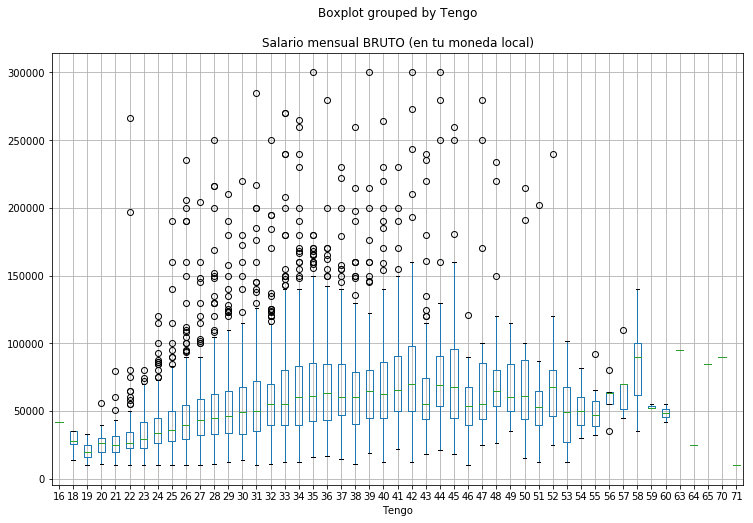

In [47]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Tengo', figsize=(12, 8));

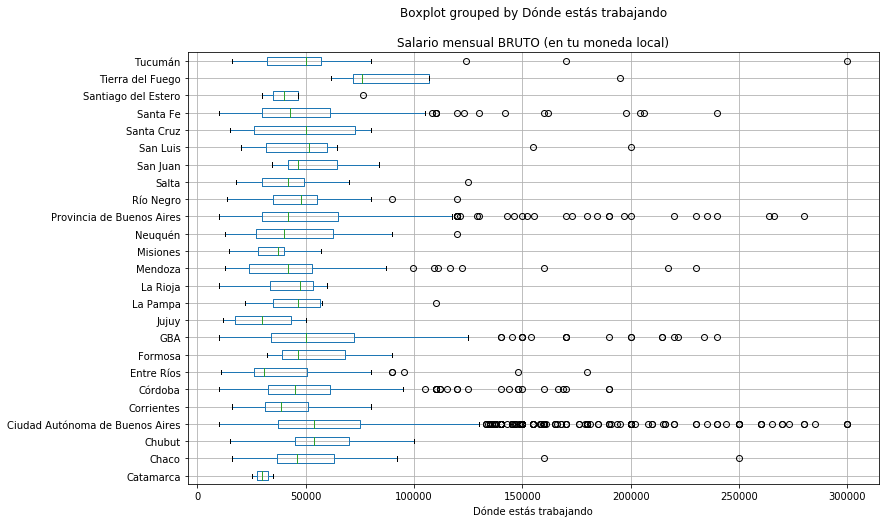

In [48]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Dónde estás trabajando', figsize=(12, 8), vert=False);

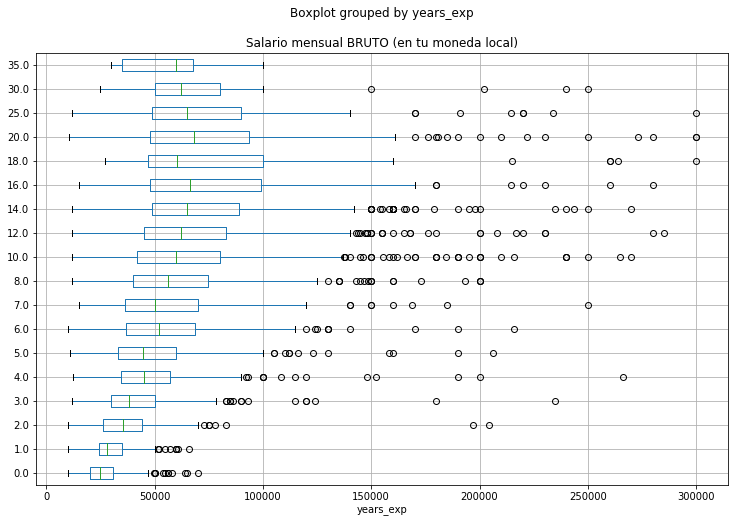

In [49]:
def years_exp(y):
    if y < 8: return int(y)
    if y < 20: return 2 * (y // 2) # 6->6, 7->6, 8->8, 9->8
    return (y // 5) * 5
    
df['years_exp'] = df['Años de experiencia'].apply(years_exp)# .value_counts(sort=True, ascending=True).tail(20).plot.barh();
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'years_exp', figsize=(12, 8), vert=False);

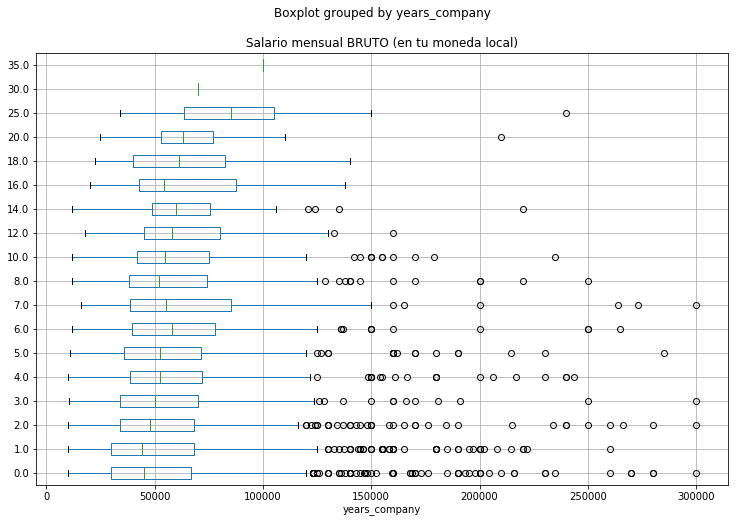

In [50]:
df['years_company'] = df['Años en la empresa actual'].apply(years_exp)
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'years_company', figsize=(12, 8), vert=False);

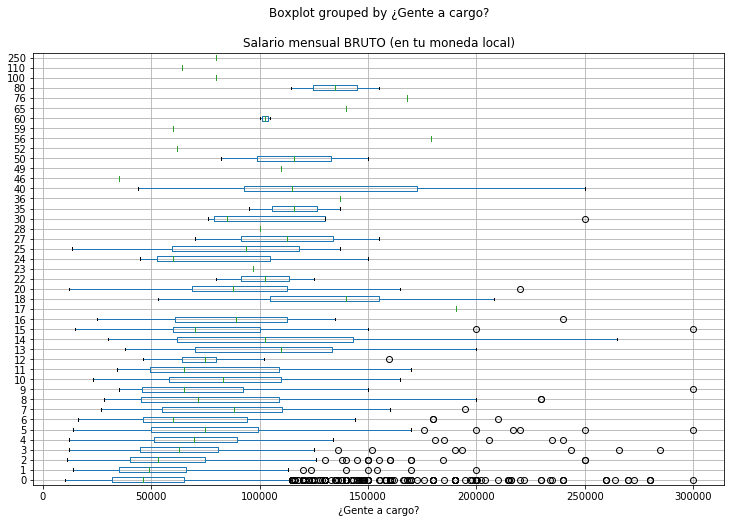

In [51]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Gente a cargo?', figsize=(12, 8), vert=False);

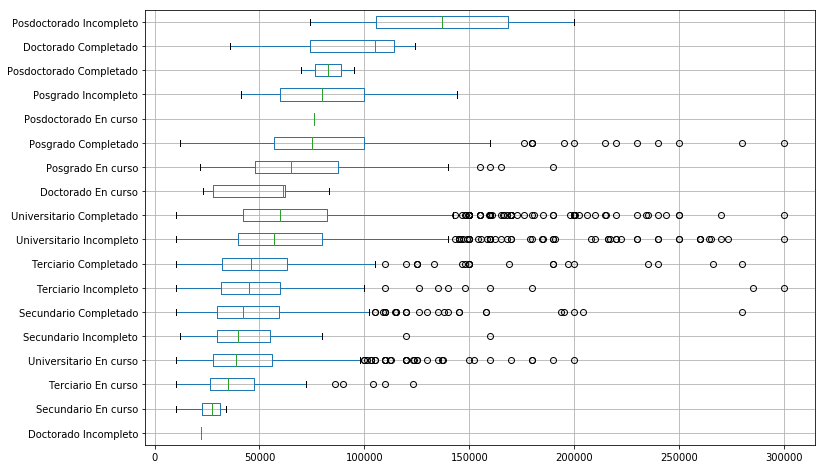

In [52]:
def boxplot_sorted(df, by, column):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(figsize=(12, 8), vert=False)

df['studied'] = df.apply(lambda row: '{} {}'.format(row['Nivel de estudios alcanzado'], row['Estado']), axis=1)

boxplot_sorted(df, by=["studied"], column="Salario mensual BRUTO (en tu moneda local)")

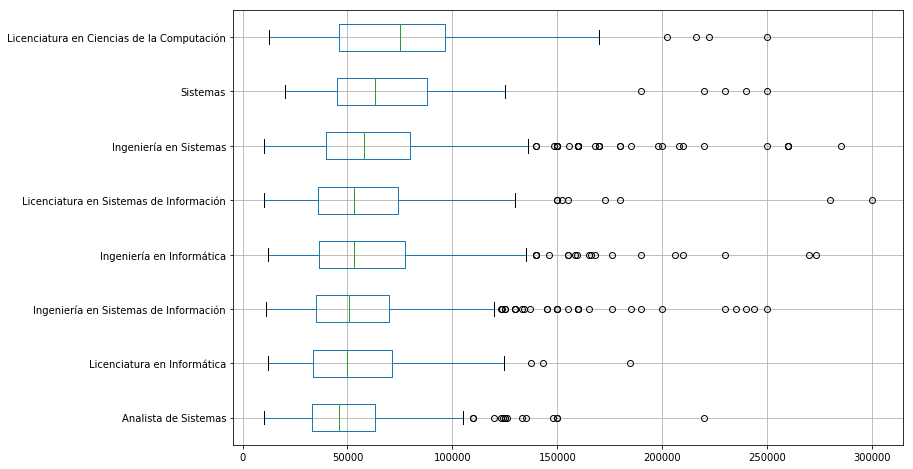

In [53]:
df['Carrera'].value_counts(sort=True, ascending=True).tail(20)#.plot.barh();
valid_carrera = 'Sistemas','Licenciatura en Informática','Licenciatura en Sistemas de Información','Licenciatura en Ciencias de la Computación','Ingeniería en Sistemas','Analista de Sistemas','Ingeniería en Informática','Ingeniería en Sistemas de Información'
boxplot_sorted(df[df['Carrera'].apply(lambda c: c in valid_carrera)], by=["Carrera"], column="Salario mensual BRUTO (en tu moneda local)")

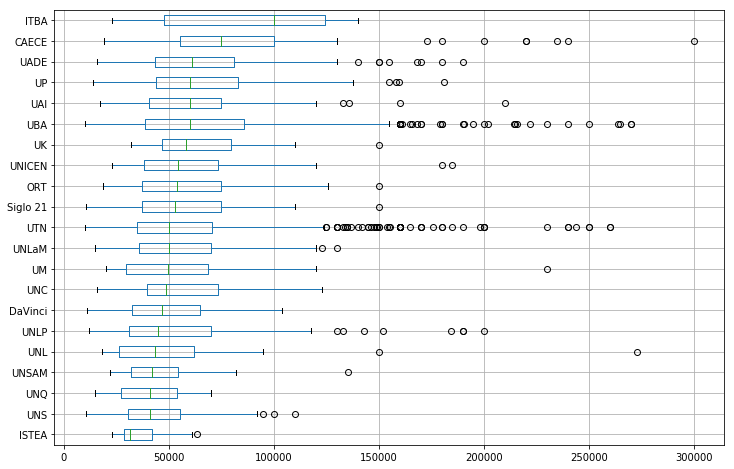

In [54]:
vc = df['Universidad'].value_counts()
univs = vc[vc > 20].index.tolist()
boxplot_sorted(df[df['Universidad'].apply(lambda c: c in univs)], by=["Universidad"], column="Salario mensual BRUTO (en tu moneda local)")

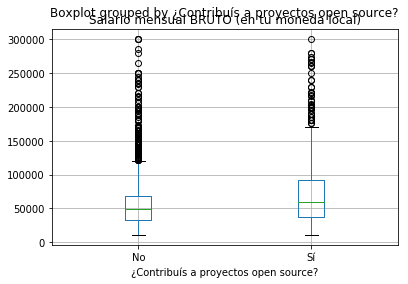

In [55]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Contribuís a proyectos open source?');

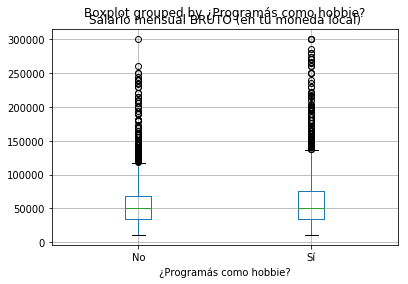

In [56]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Programás como hobbie?');

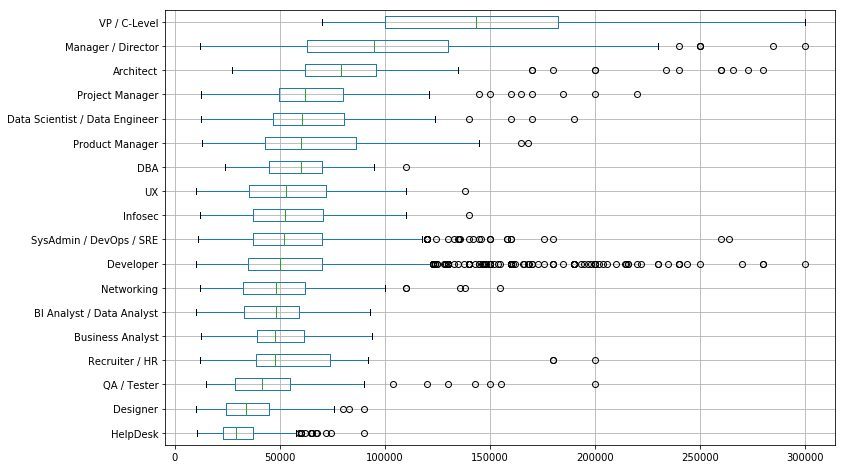

In [57]:
vc = df['Trabajo de'].value_counts()
univs = vc[vc > 20].index.tolist()
boxplot_sorted(df[df['Trabajo de'].apply(lambda c: c in univs)], by=["Trabajo de"], column="Salario mensual BRUTO (en tu moneda local)")

In [58]:
tech_counts = pd.Series(tech_count).sort_values(ascending=True)
tech_counts = tech_counts[tech_counts > 20]
tech_counts

SAP                                   28
HP-UX                                 73
*BSD                                  95
Mainframe                             97
IBM Cloud / Watson                   108
Solaris                              116
AIX                                  129
Heroku                               131
OpenStack                            136
Serverless                           193
Firebase                             213
Kubernetes                           375
Google Cloud Platform/App Engine     398
Azure                                510
VMWare                               806
Amazon Web Services                 1068
Docker                              1100
Windows Server                      1557
Linux                               2147
dtype: int64

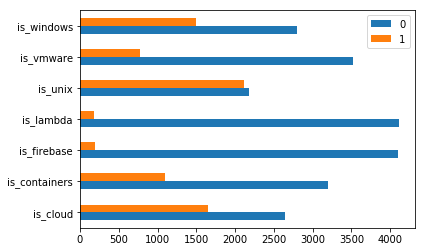

In [59]:
d = {}
for key, tech in {
        'unix': ('Linux', '*BSD', 'AIX', 'OpenStack', 'Solaris', 'HP-UX'),
        'windows': ('Windows', 'Windows Server'),
        'vmware': ('VMWare',),
        'containers': ('Docker', 'Kubernetes'),
        'cloud': ('Azure', 'Amazon Web Services', 'Google Cloud Platform/App Engine', 'OpenStack', 'Heroku', 'IBM Cloud / Watson',),
        'firebase': ('Firebase',),
        'lambda': ('Serverless',),
    }.items():
    d['is_{}'.format(key)] = df['Plataformas'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Plataformas'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

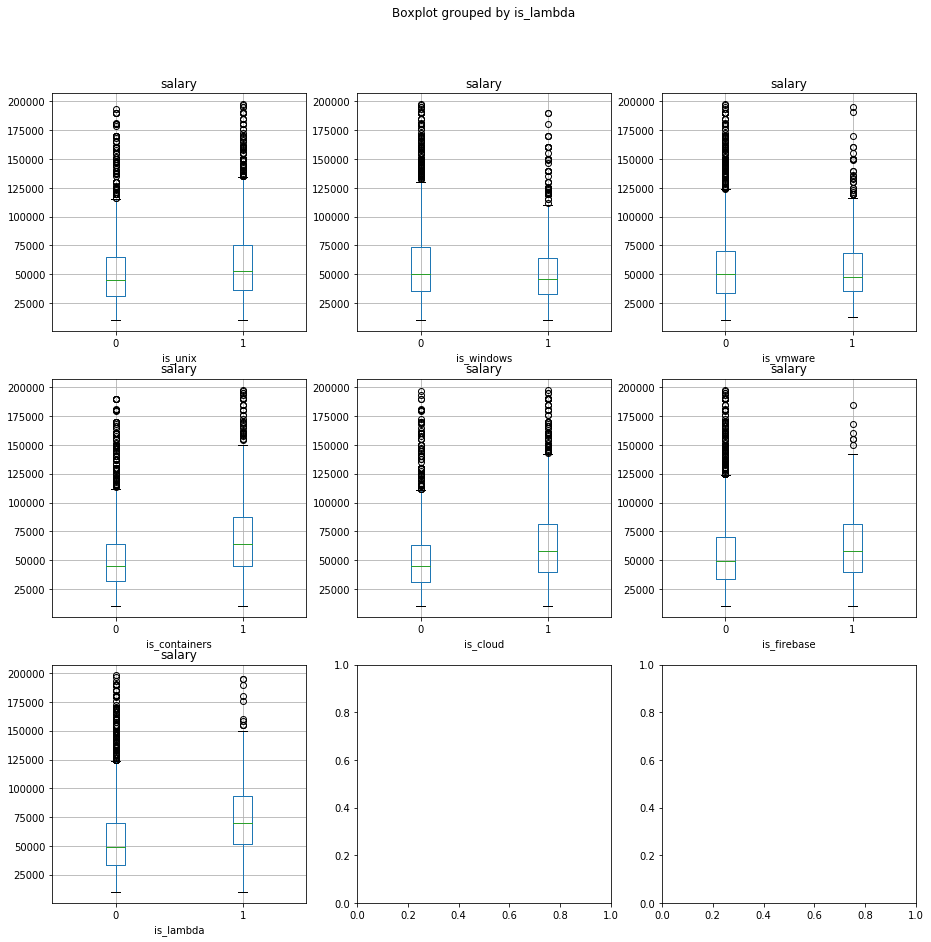

In [60]:
import matplotlib.pyplot as plt
_, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, _, _)) = plt.subplots(3, 3, figsize=(15, 15))
df['salary'] = df['Salario mensual BRUTO (en tu moneda local)']
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_unix', ax=ax1);
df_low.boxplot('salary', 'is_windows', ax=ax2);
df_low.boxplot('salary', 'is_vmware', ax=ax3);
df_low.boxplot('salary', 'is_containers', ax=ax4);
df_low.boxplot('salary', 'is_cloud', ax=ax5);
df_low.boxplot('salary', 'is_firebase', ax=ax6);
df_low.boxplot('salary', 'is_lambda', ax=ax7);

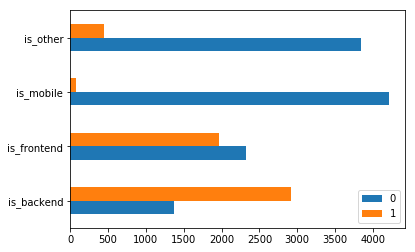

In [61]:
d = {}
for key, tech in {
        'frontend': ('Javascript', 'HTML', 'CSS', 'jQuery'),
        'backend': ('Java', 'PHP', 'Python', '.NET', 'NodeJS', 'C#', 'Ruby', 'Perl', 'Go', 'Scala'),
        'other': ('VB*', 'C++', 'C,', 'ABAP'),
        'mobile': ('Swift', 'Objective-C')
    }.items():
    d['is_{}'.format(key)] = df['Lenguajes de programación'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Lenguajes de programación'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

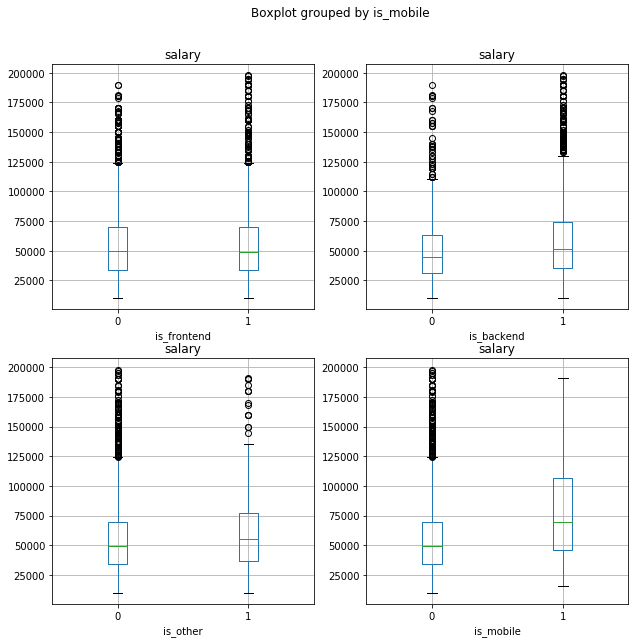

In [64]:
import matplotlib.pyplot as plt
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_frontend', ax=ax1);
df_low.boxplot('salary', 'is_backend', ax=ax2);
df_low.boxplot('salary', 'is_other', ax=ax3);
df_low.boxplot('salary', 'is_mobile', ax=ax4);

In [65]:
fw_counts = pd.Series(fw_count).sort_values(ascending=True)
fw_counts = fw_counts[fw_counts > 20]
fw_counts

Rails          22
Vue.js         23
Torch          24
Laravel        39
TensorFlow     81
Hadoop         85
Drupal         99
Spark         109
Cordova       142
Django        251
WordPress     365
Spring        447
.NET Core     520
React.js      620
Angular       689
Node.js       925
dtype: int64

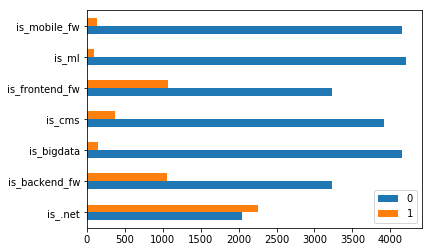

In [66]:
d = {}
for key, tech in {
        'frontend_fw': ('Angular', 'React.js', 'Vue.js'),
        'backend_fw': ('Node.js', 'Django', 'Laravel'),
        'mobile_fw': ('Cordova',),
        '.net': ('.NET Core'),
        'cms': ('WordPress', 'Drupal'),
        'bigdata': ('Spark', 'Hadoop'),
        'ml': ('TensorFlow', 'Torch',),
    }.items():
    d['is_{}'.format(key)] = df['Frameworks, herramientas y librerías'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Frameworks, herramientas y librerías'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

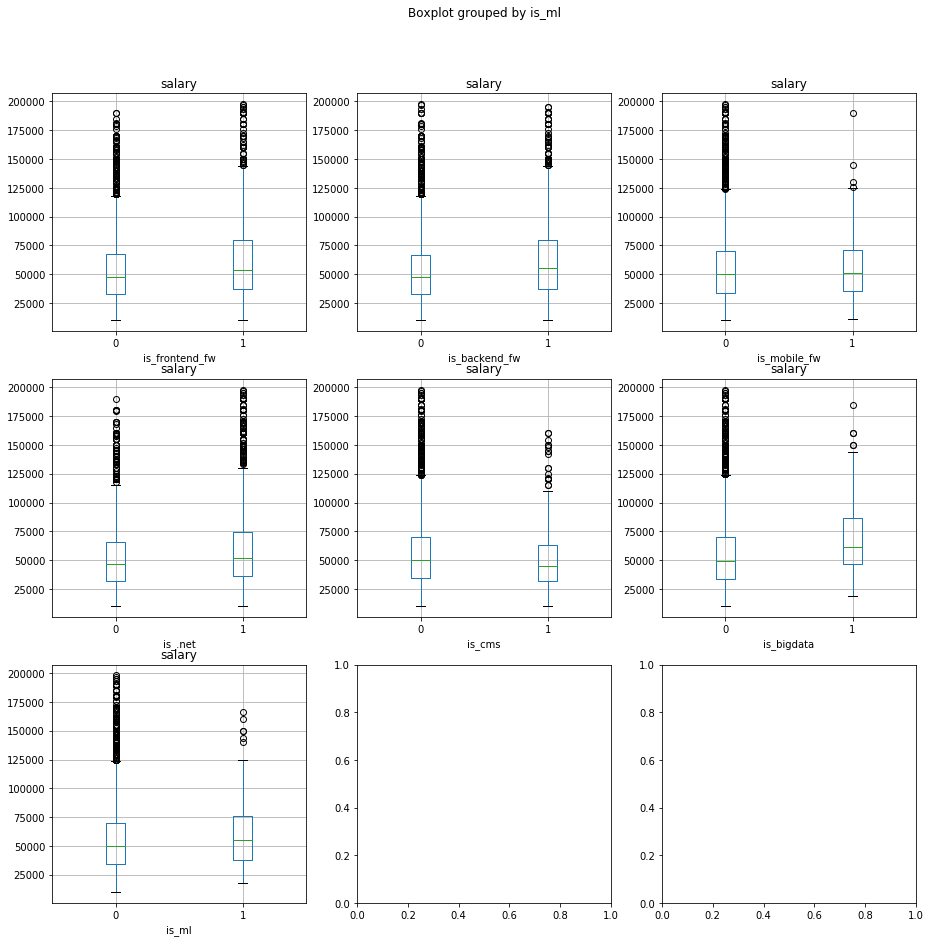

In [67]:
import matplotlib.pyplot as plt
_, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, _, _)) = plt.subplots(3, 3, figsize=(15, 15))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_frontend_fw', ax=ax1);
df_low.boxplot('salary', 'is_backend_fw', ax=ax2);
df_low.boxplot('salary', 'is_mobile_fw', ax=ax3);
df_low.boxplot('salary', 'is_.net', ax=ax4);
df_low.boxplot('salary', 'is_cms', ax=ax5);
df_low.boxplot('salary', 'is_bigdata', ax=ax6);
df_low.boxplot('salary', 'is_ml', ax=ax7);

In [68]:
db_counts = pd.Series(db_count).sort_values(ascending=True)
db_counts = db_counts[db_counts > 20]
db_counts

Teradata                     22
Percona Server               22
ProxySQL                     23
Neo4j                        34
Apache HBase                 58
Informix                     62
Apache Hive                  80
Amazon Redshift              92
Google Cloud Storage        121
IBM Db2                     133
Cassandra                   172
Amazon RDS/Aurora           191
Amazon DynamoDB             204
CosmosDB                    239
etc)                        239
Microsoft Azure (Tables     239
SQL                         239
Redis                       376
SQLite                      389
ElasticSearch               389
MariaDB                     571
MongoDB                     661
Oracle                      671
PostgreSQL                  886
MSSQL                      1191
MySQL                      1703
dtype: int64

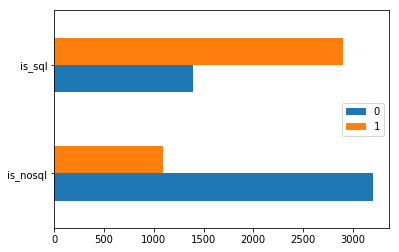

In [69]:
d = {}
for key, tech in {
        'sql': ('MySQL', 'MSSQL', 'PostgreSQL', 'Oracle', 'MariaDB', 'Microsoft Azure', 'IBM Db2'),
        'nosql': ('MongoDB', 'ElasticSearch', 'Redis', 'Amazon DynamoDB', 'Cassandra', 'Google Cloud Storage'),
    }.items():
    d['is_{}'.format(key)] = df['Bases de datos'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['Bases de datos'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

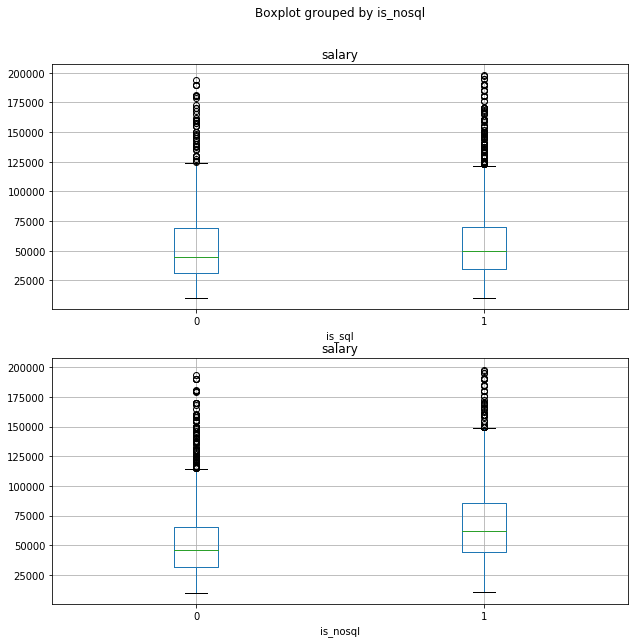

In [70]:
import matplotlib.pyplot as plt
_, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(10, 10))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_sql', ax=ax1);
df_low.boxplot('salary', 'is_nosql', ax=ax2);

In [71]:
qat_counts = pd.Series(qat_count).sort_values(ascending=True)
qat_counts = qat_counts[qat_counts > 20]
qat_counts

HP LoadRunner              35
OpenQA                     36
Test Complete              49
RSpec                      58
Visual Studio Coded UI    128
Selenium                  418
dtype: int64

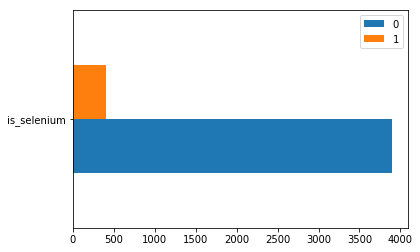

In [72]:
d = {}
for key, tech in {
        'selenium': ('Selenium',),
    }.items():
    d['is_{}'.format(key)] = df['QA / Testing'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['QA / Testing'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

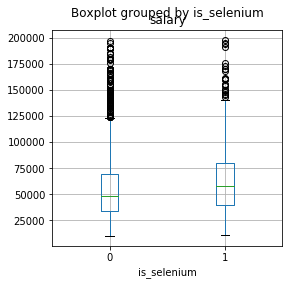

In [73]:
import matplotlib.pyplot as plt
_, ((ax1)) = plt.subplots(1, 1, figsize=(4, 4))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]
df_low.boxplot('salary', 'is_selenium', ax=ax1);

In [74]:
ide_counts = pd.Series(ide_count).sort_values(ascending=True)
ide_counts = ide_counts[ide_counts > 200]
ide_counts

NetBeans           209
PyCharm            212
Vi                 347
Atom               373
Android Studio     381
Eclipse            606
IntelliJ           618
Vim                625
Notepad++          783
Sublime Text       861
Visual Studio     1308
dtype: int64

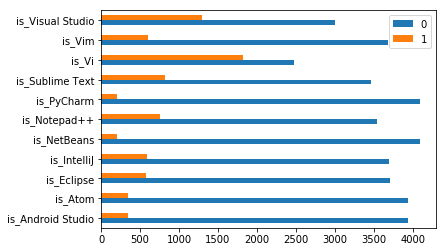

In [75]:
d = {}
for ide in ide_counts.index.tolist():
    key, tech = ide, (ide,)
    d['is_{}'.format(key)] = df['IDEs'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
    df['is_{}'.format(key)] = df['IDEs'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh();

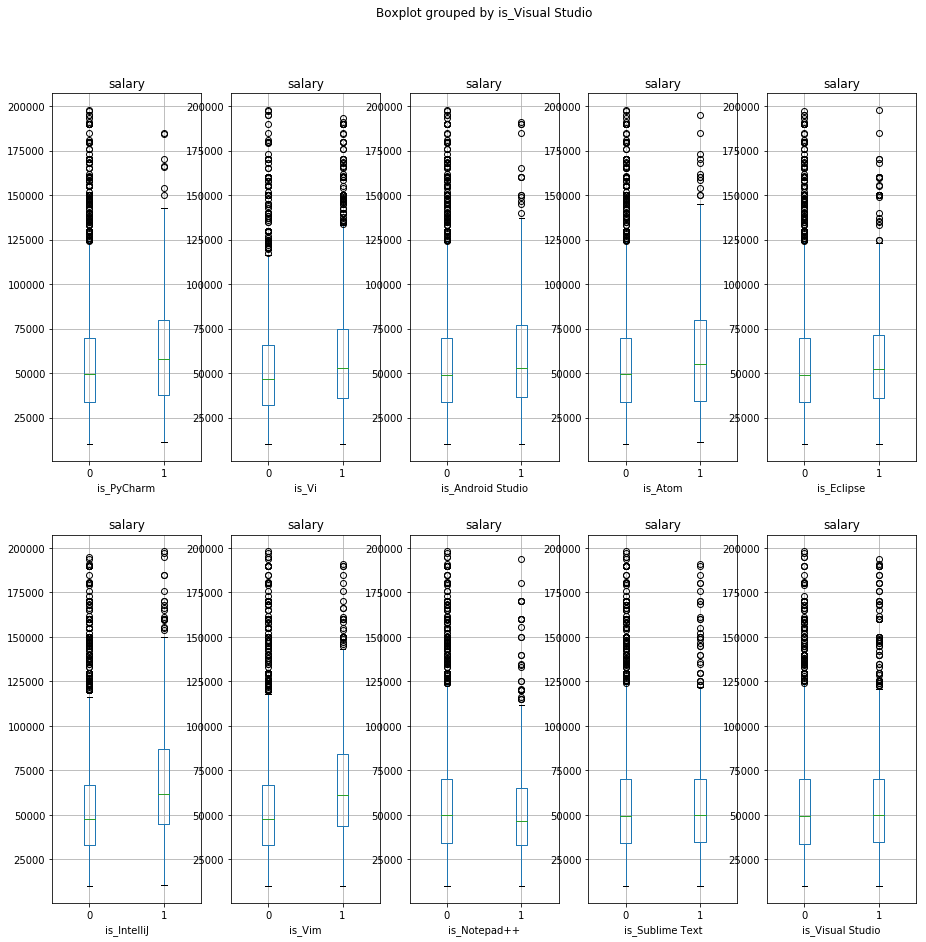

In [76]:
import matplotlib.pyplot as plt
_, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(15, 15))
df_low = df[df['Salario mensual BRUTO (en tu moneda local)'] < 200000]

df_low.boxplot('salary', 'is_PyCharm', ax=ax1);
df_low.boxplot('salary', 'is_Vi', ax=ax2);
df_low.boxplot('salary', 'is_Android Studio', ax=ax3);
df_low.boxplot('salary', 'is_Atom', ax=ax4);
df_low.boxplot('salary', 'is_Eclipse', ax=ax5);
df_low.boxplot('salary', 'is_IntelliJ', ax=ax6);
df_low.boxplot('salary', 'is_Vim', ax=ax7);
df_low.boxplot('salary', 'is_Notepad++', ax=ax8);
df_low.boxplot('salary', 'is_Sublime Text', ax=ax9);
df_low.boxplot('salary', 'is_Visual Studio', ax=ax10);

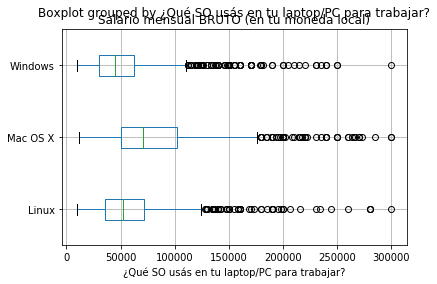

In [77]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Qué SO usás en tu laptop/PC para trabajar?', vert=False);

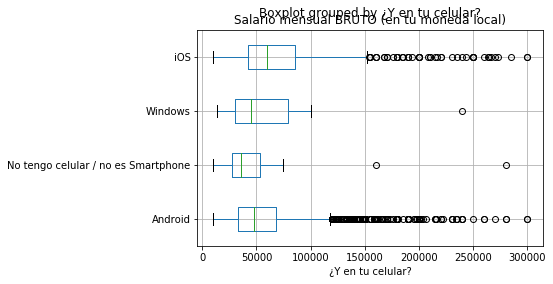

In [78]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Y en tu celular?', vert=False);

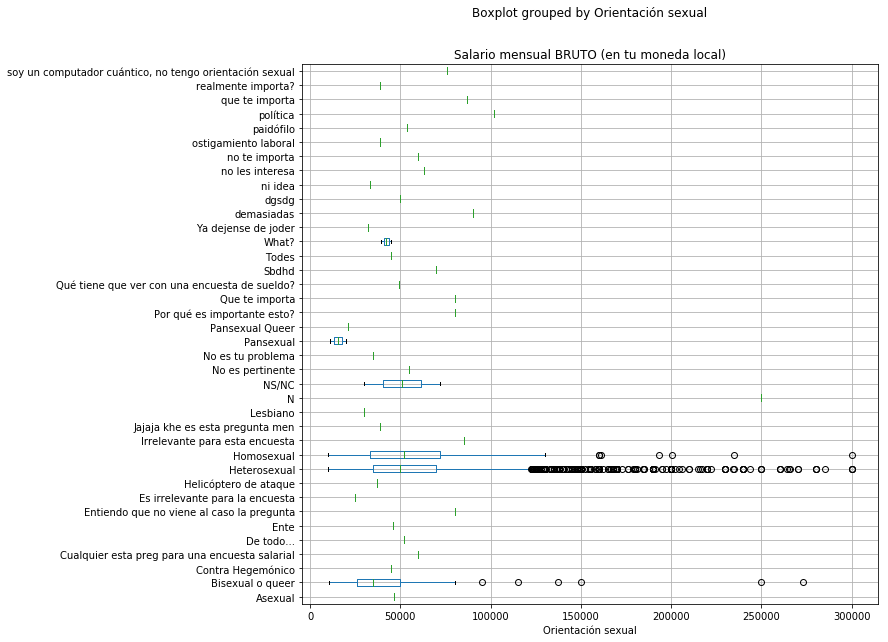

In [79]:
df.boxplot('Salario mensual BRUTO (en tu moneda local)', 'Orientación sexual', vert=False, figsize=(10, 10));

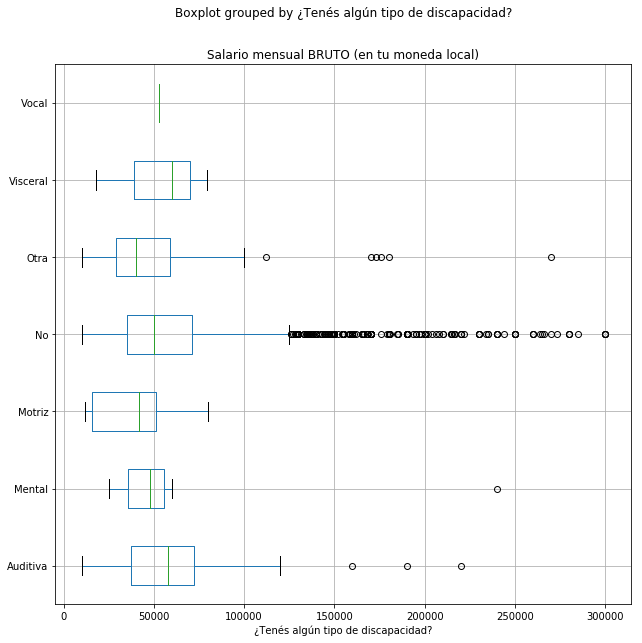

In [83]:
df_copy = df
df_copy['¿Tenés algún tipo de discapacidad?'] = df_copy['¿Tenés algún tipo de discapacidad?'].fillna('No')
df_copy.boxplot('Salario mensual BRUTO (en tu moneda local)', '¿Tenés algún tipo de discapacidad?', vert=False, figsize=(10, 10));